In [39]:
import pandas as pd
from pandas.tseries.frequencies import to_offset
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from chart_studio.plotly import plot_mpl
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

In [40]:
nvidia = pd.read_csv('./data/Nvidia_history.csv')
amd = pd.read_csv('./data/AMD_stock_price_history.csv')
nvidia_trend = pd.read_csv('./data/Nvidia_google_trend.csv')

In [41]:
nvidia

,Date,Open,High,Low,Close,Adj Close,Volume,Revenue,Future,Market_share
0,1/22/1999,1.750000,1.953125,1.552083,1.640625,1.507891,67867200,NaN,NaN,NaN
1,1/25/1999,1.770833,1.833333,1.640625,1.812500,1.665861,12762000,NaN,NaN,NaN
2,1/26/1999,1.833333,1.869792,1.645833,1.671875,1.536613,8580000,NaN,NaN,NaN
3,1/27/1999,1.677083,1.718750,1.583333,1.666667,1.531826,6109200,NaN,NaN,NaN
4,1/28/1999,1.666667,1.677083,1.651042,1.661458,1.527039,5688000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5624,5/28/2021,620.039978,651.099976,620.039978,649.780029,649.780029,16113400,$5.66B,NaN,80.0
5625,6/1/2021,650.799988,655.530029,636.130005,650.580017,650.580017,11820100,$5.66B,NaN,80.0
5626,6/2/2021,650.090027,676.750000,649.419983,671.130005,671.130005,14854200,$5.66B,NaN,80.0
5627,6/3/2021,668.030029,690.359985,663.320007,678.789978,678.789978,14500200,$5.66B,NaN,80.0


In [42]:
nvidia['daily_change'] = (nvidia.Close - nvidia.Open) / nvidia.Open * 100

In [43]:
nvidia['daily_change'] = nvidia['daily_change'].shift(1)
nvidia.drop(columns=['Volume', 'Open', 'High', 'Low', 'Adj Close'], inplace=True)
nvidia1 = nvidia['Revenue'].str.strip('$').str.extract(r'(\d+\.\d+)([BM]+)')
nvidia['Revenue'] = nvidia1[0].astype(float) * nvidia1[1].map({'B': 1000000000, 'M':1000000})

In [44]:
amd['previous_amd_close_price'] = amd['Close'].shift(1)
amd.drop(columns=['Open', 'High', 'Low', 'Adj Close','Volume', 'Close'], inplace=True)

In [45]:
amd

,Date,previous_amd_close_price
0,3/17/1980,NaN
1,3/18/1980,3.145833
2,3/19/1980,3.031250
3,3/20/1980,3.041667
4,3/21/1980,3.010417
...,...,...
10394,6/7/2021,81.580002
10395,6/8/2021,81.349998
10396,6/9/2021,80.889999
10397,6/10/2021,79.959999


In [46]:
nvidia = nvidia.merge(amd, on='Date', how='left')

In [47]:
nvidia

,Date,Close,Revenue,Future,Market_share,daily_change,previous_amd_close_price
0,1/22/1999,1.640625,NaN,NaN,NaN,NaN,10.500000
1,1/25/1999,1.812500,NaN,NaN,NaN,-6.250000,10.781250
2,1/26/1999,1.671875,NaN,NaN,NaN,2.352960,10.718750
3,1/27/1999,1.666667,NaN,NaN,NaN,-8.806802,11.000000
4,1/28/1999,1.661458,NaN,NaN,NaN,-0.621078,10.625000
...,...,...,...,...,...,...,...
5624,5/28/2021,649.780029,5.660000e+09,NaN,80.0,-1.348743,78.419998
5625,6/1/2021,650.580017,5.660000e+09,NaN,80.0,4.796473,80.080002
5626,6/2/2021,671.130005,5.660000e+09,NaN,80.0,-0.033800,80.809998
5627,6/3/2021,678.789978,5.660000e+09,NaN,80.0,3.236471,81.970001


In [48]:
nvidia_trend

,Month,Nvidia
0,2004-01,96
1,2004-02,80
2,2004-03,88
3,2004-04,84
4,2004-05,79
...,...,...
205,2021-02,37
206,2021-03,33
207,2021-04,33
208,2021-05,33


In [49]:
trend = []
for date in nvidia['Date']:
    month = date.split('/')[0]
    if int(month) < 10:
        month = f'0{month}'
    else:
        month = month
    year = date.split('/')[2]
    year_month = f'{year}-{month}'
    if int(year) < 2004:
        trend.append(0)
    else:
        trend.append(int(nvidia_trend.Nvidia[nvidia_trend.Month == year_month]))

In [50]:
nvidia['trend'] = trend
nvidia['trend'] = nvidia['trend'].astype(int)

In [51]:
nvidia

,Date,Close,Revenue,Future,Market_share,daily_change,previous_amd_close_price,trend
0,1/22/1999,1.640625,NaN,NaN,NaN,NaN,10.500000,0
1,1/25/1999,1.812500,NaN,NaN,NaN,-6.250000,10.781250,0
2,1/26/1999,1.671875,NaN,NaN,NaN,2.352960,10.718750,0
3,1/27/1999,1.666667,NaN,NaN,NaN,-8.806802,11.000000,0
4,1/28/1999,1.661458,NaN,NaN,NaN,-0.621078,10.625000,0
...,...,...,...,...,...,...,...,...
5624,5/28/2021,649.780029,5.660000e+09,NaN,80.0,-1.348743,78.419998,33
5625,6/1/2021,650.580017,5.660000e+09,NaN,80.0,4.796473,80.080002,39
5626,6/2/2021,671.130005,5.660000e+09,NaN,80.0,-0.033800,80.809998,39
5627,6/3/2021,678.789978,5.660000e+09,NaN,80.0,3.236471,81.970001,39


In [52]:
nvidia['Date'] = pd.to_datetime(nvidia['Date'])
nvidia = nvidia[nvidia.Date >= '2017-01-01']
nvidia = nvidia.set_index('Date')

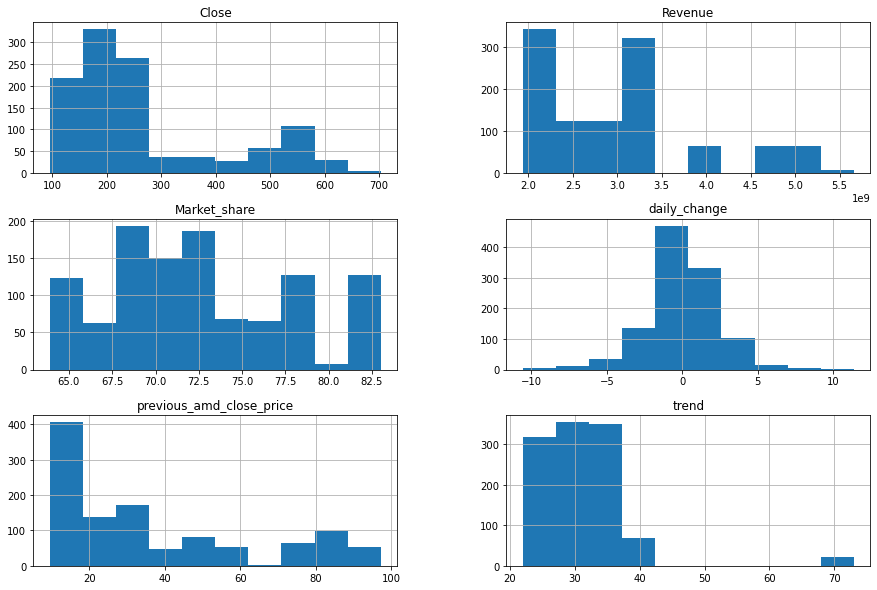

In [53]:
fig, ax = plt.subplots(figsize = (15,10))
nvidia.hist(bins = 10, ax=ax)
fig.savefig('./images/variables_distribution.png')

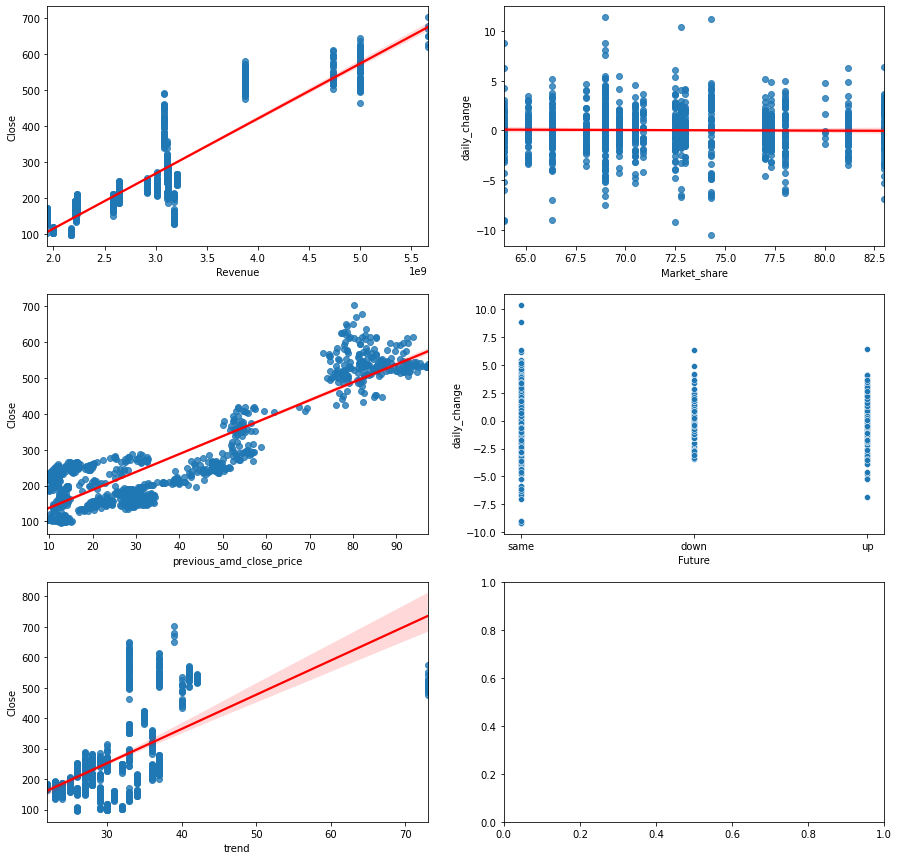

In [55]:
# create regression plots to check the relationship between price and other variables
fig, axes = plt.subplots(3, 2, figsize=(15,15))
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]
ax5 = axes[2][0]
X = nvidia.drop('Close', axis = 1)
y = nvidia['Close']
sns.regplot(x=X['Revenue'], y=y, line_kws={"color": "red"}, ax=ax1)
sns.regplot(x=X['Market_share'], y=X['daily_change'], line_kws={"color": "red"}, ax=ax2)
sns.regplot(x=X['previous_amd_close_price'], y=y, line_kws={"color": "red"}, ax=ax3)
sns.scatterplot(x=X['Future'], y=X['daily_change'], ax=ax4)
sns.regplot(x=X['trend'], y=y, line_kws={"color": "red"}, ax=ax5)
fig.savefig('./images/close_variables_relationship.png')

In [56]:
nvidia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1113 entries, 2017-01-03 to 2021-06-04
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Close                     1113 non-null   float64
 1   Revenue                   1113 non-null   float64
 2   Future                    902 non-null    object 
 3   Market_share              1113 non-null   float64
 4   daily_change              1113 non-null   float64
 5   previous_amd_close_price  1113 non-null   float64
 6   trend                     1113 non-null   int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 65.2+ KB


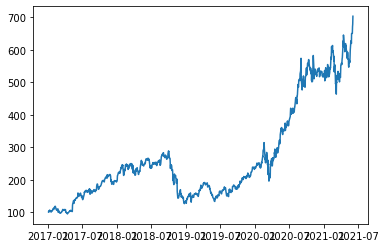

In [57]:
plt.plot(nvidia.Close)

In [58]:
monthly = nvidia.resample('MS').mean()

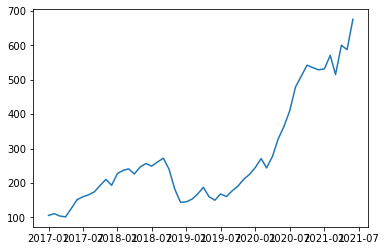

In [59]:
plt.plot(monthly['Close'])

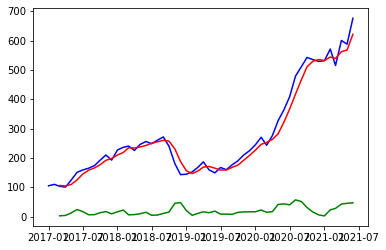

In [60]:
roll_mean = monthly['Close'].rolling(window = 3).mean()
roll_std = monthly['Close'].rolling(window = 3).std()
plt.plot(monthly['Close'], color = 'blue')
plt.plot(roll_mean, color = 'red')
plt.plot(roll_std, color = 'green')

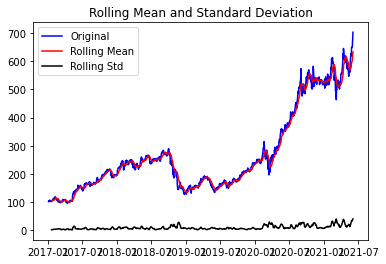

Results of dickey fuller test
Test Statistics                   1.317518
p-value                           0.996705
No. of lags used                 14.000000
Number of observations used    1098.000000
critical value (1%)              -3.436320
critical value (5%)              -2.864176
critical value (10%)             -2.568173
dtype: float64


In [61]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(nvidia.Close)

<Figure size 432x288 with 0 Axes>

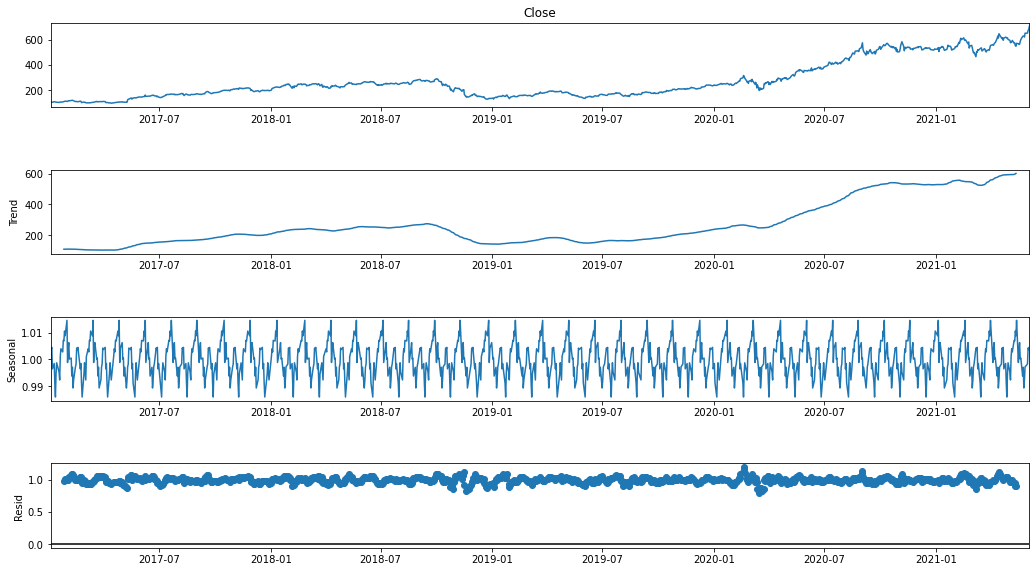

In [62]:
result = seasonal_decompose(nvidia.Close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


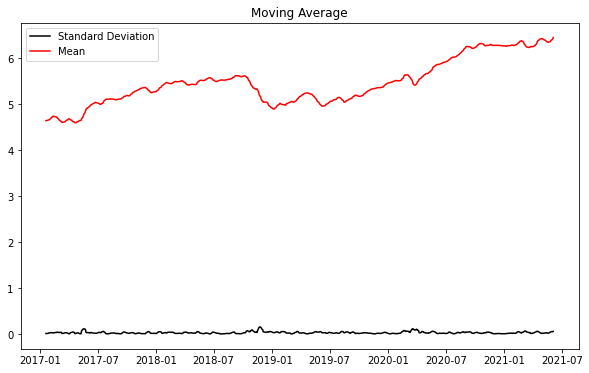

In [63]:
rcParams['figure.figsize'] = 10, 6
nvidia_stock_log = np.log(nvidia.Close)
moving_avg = nvidia_stock_log.rolling(12).mean()
std_dev = nvidia_stock_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

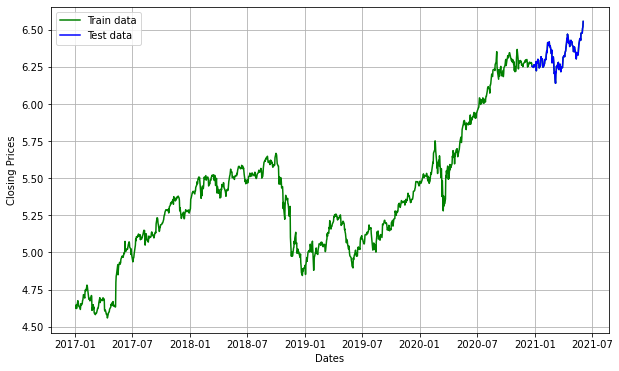

In [64]:
train_data, test_data = nvidia_stock_log[3:int(len(nvidia_stock_log)*0.90)], nvidia_stock_log[int(len(nvidia_stock_log)*0.90):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(nvidia_stock_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [65]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4141.951, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4154.961, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4153.450, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4141.011, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4155.158, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4153.750, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4152.933, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4154.371, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4151.719, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4153.768, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.057 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  998
Model:               SARIMAX(2, 1, 0)   Log Likeliho

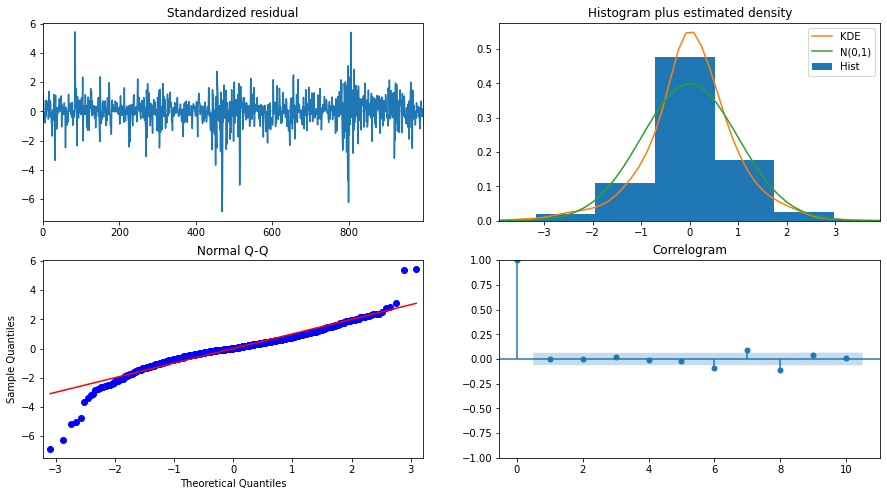

In [66]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [85]:
model = ARIMA(train_data, order=(2, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  997
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2082.152
Method:                       css-mle   S.D. of innovations              0.030
Date:                Tue, 15 Jun 2021   AIC                          -4152.304
Time:                        10:11:16   BIC                          -4122.876
Sample:                             1   HQIC                         -4141.118
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.001      1.787      0.074      -0.000       0.003
ar.L1.D.Close     0.1618      0.301      0.538      0.591      -0.428       0.752
ar.L2.D.Close    -0.2472      0.326     

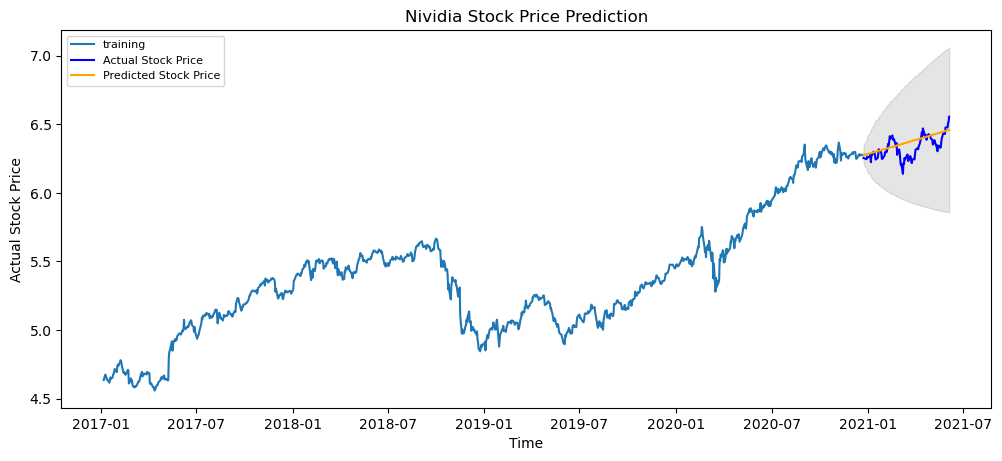

In [86]:
# Forecast
fc, se, conf = fitted.forecast(112, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nividia Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [87]:
MSE = np.square(np.subtract(test_data,fc_series)).mean() 
 
RMSE = math.sqrt(MSE)
RMSE

0.07403451434446372

In [70]:
exo_df = nvidia.drop(columns=['Close', 'Future', 'trend', 'Revenue'])
train_exo_data, test_exo_data = exo_df[3:int(len(exo_df)*0.90)], exo_df[int(len(exo_df)*0.90):]

In [71]:
model_autoARIMA_exo = auto_arima(train_data, exogenous=train_exo_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_exo.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4153.797, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4153.462, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4153.089, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4152.061, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4151.844, Time=1.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.770 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  998
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2081.899
Date:                Tue, 15 Jun 2021   AIC                          -4153.797
Time:                        10:07:32   BIC                          -4129.273
Sample:                             0   HQIC                         -4144.475
                                - 998                                  

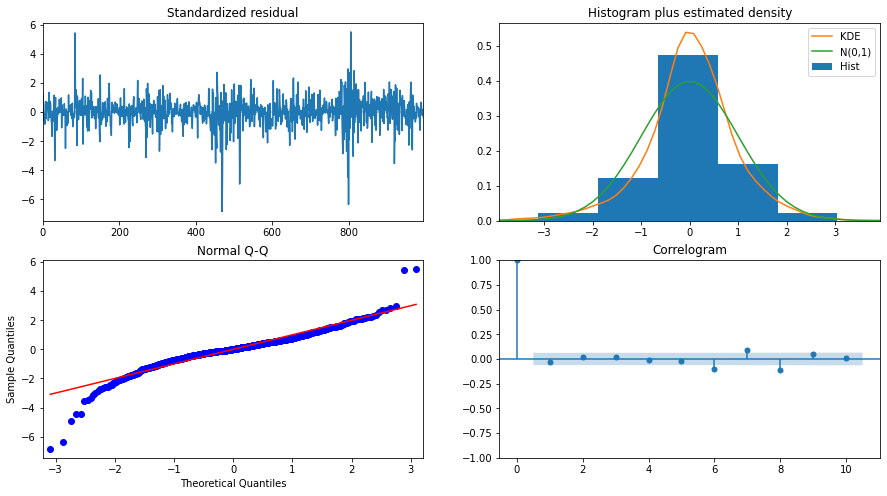

In [72]:
model_autoARIMA_exo.plot_diagnostics(figsize=(15,8))
plt.show()

In [89]:
model2 = ARIMA(train_data, exog=train_exo_data, order=(2, 1, 2))  
fitted = model2.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  997
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2082.650
Method:                       css-mle   S.D. of innovations              0.030
Date:                Tue, 15 Jun 2021   AIC                          -4147.300
Time:                        10:13:14   BIC                          -4103.157
Sample:                             1   HQIC                         -4130.520
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0083      0.015      0.567      0.570      -0.020       0.037
Market_share              -9.76e-05      0.000     -0.467      0.640      -0.001       0.

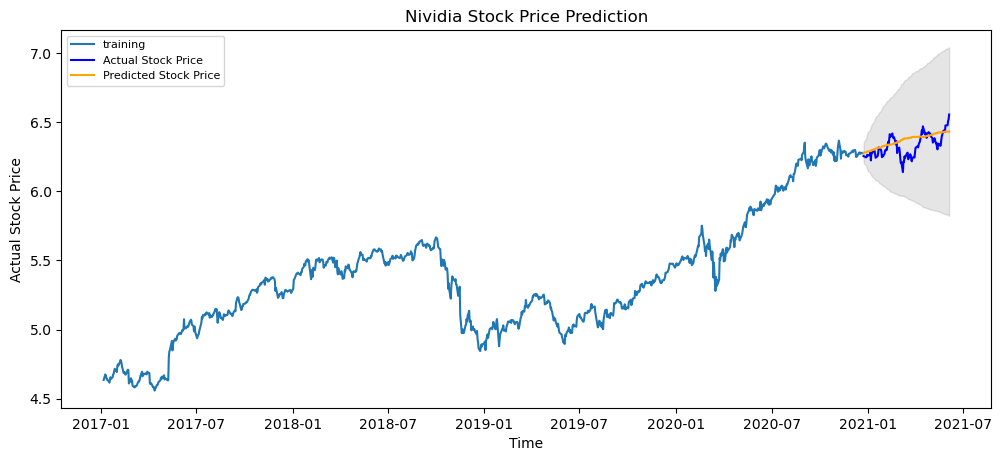

In [90]:
# Forecast
fc, se, conf = fitted.forecast(112, exog=test_exo_data, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nividia Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [91]:
MSE = np.square(np.subtract(test_data,fc_series)).mean() 
 
RMSE = math.sqrt(MSE)
RMSE

0.07933473551694561

In [519]:
nvidia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1365 entries, 2016-01-04 to 2021-06-04
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Close                         1365 non-null   float64
 1   Revenue                       1240 non-null   float64
 2   Future                        1030 non-null   object 
 3   Market_share                  1365 non-null   float64
 4   daily_change                  1365 non-null   float64
 5   previous_vol_mutiplie_change  1365 non-null   float64
 6   previous_bitcoin_close_price  1365 non-null   float64
 7   trend                         1365 non-null   int32  
dtypes: float64(6), int32(1), object(1)
memory usage: 90.6+ KB


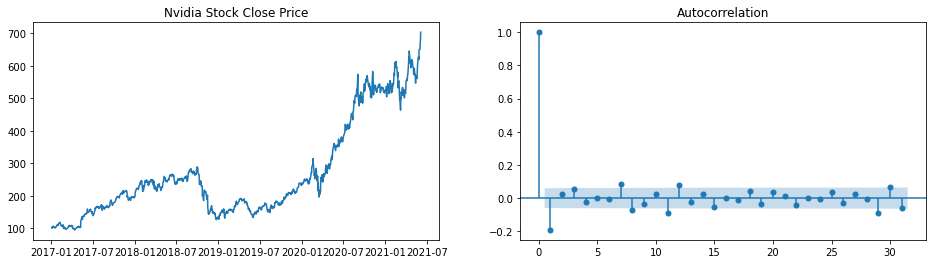

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df.Close)
ax1.set_title('Nvidia Stock Close Price')
plot_acf(df.daily_change, ax=ax2);

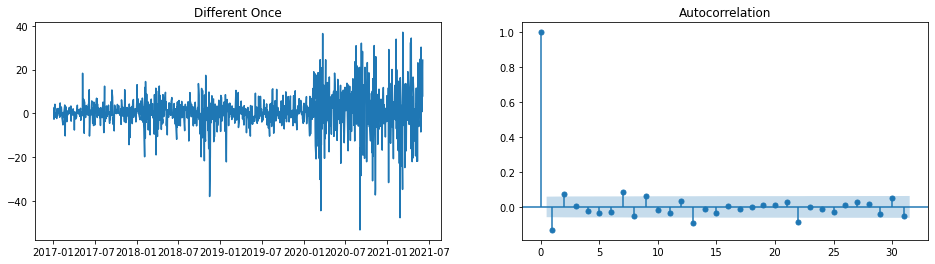

In [67]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Different Once')
plot_acf(diff, ax=ax2);

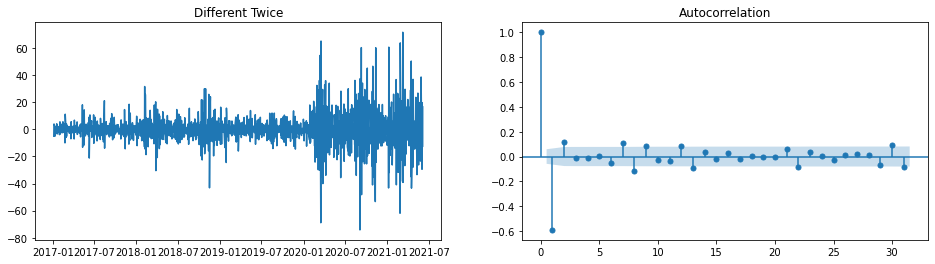

In [68]:
diff2 = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff2)
ax1.set_title('Different Twice')
plot_acf(diff2, ax=ax2);

In [21]:
ndiffs(df.daily_change, test='adf')

0

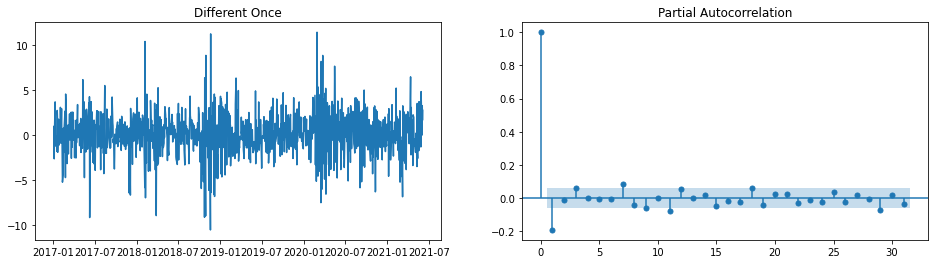

In [22]:
diff = df.daily_change.dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Different Once')
plot_pacf(diff, ax=ax2);

In [23]:
df_close

,Close
Date,
2017-01-03,102.010002
2017-01-04,104.389999
2017-01-05,101.739998
2017-01-06,103.099998
2017-01-09,107.279999
...,...
2021-05-28,649.780029
2021-06-01,650.580017
2021-06-02,671.130005


In [24]:
df_close.asfreq(df_close.index.freq or to_offset(timeframe.Timespan).freqstr)

NameError: name 'timeframe' is not defined

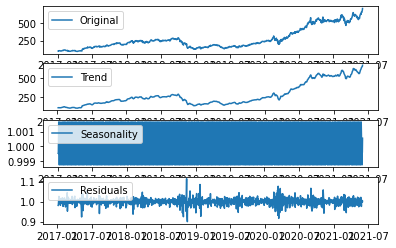

<Figure size 432x288 with 0 Axes>

In [25]:
decomposition = seasonal_decompose(df_close, model='multiplicative', period=5)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
plt.tight_layout()

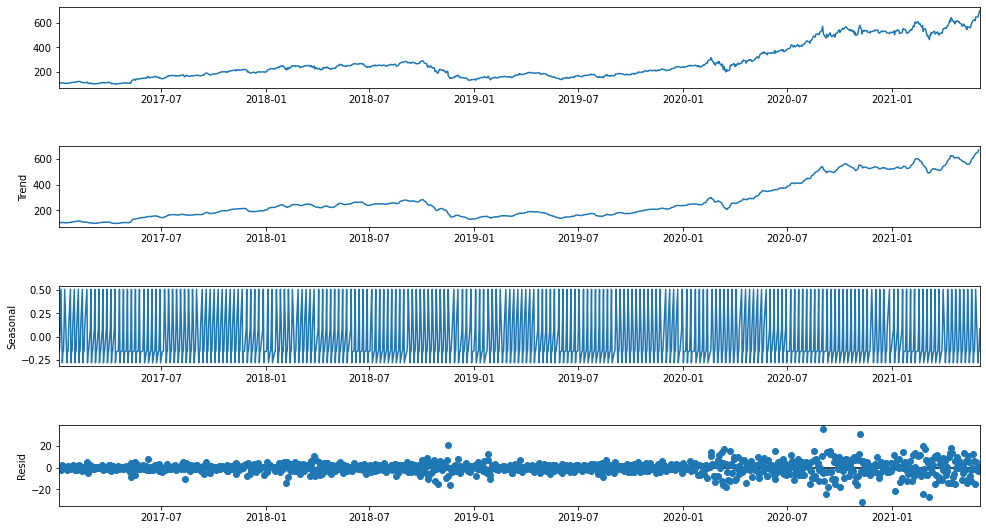

In [26]:
res = sm.tsa.seasonal_decompose(df_close, model='additive', period=5)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [668]:
result = seasonal_decompose(df_close, model='multiplicative')
fig = result.plot()
plot_mpl(fig)

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [669]:
df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2021-05-21', '2021-05-24', '2021-05-25', '2021-05-26',
               '2021-05-27', '2021-05-28', '2021-06-01', '2021-06-02',
               '2021-06-03', '2021-06-04'],
              dtype='datetime64[ns]', name='Date', length=1113, freq=None)

In [ ]:
base_arima_model = ARIMA(df.daily_change, (1,0,1), )

In [27]:
auto_arima_model = auto_arima(df.daily_change, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.86 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6589.858, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5900.817, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6167.947, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5826.824, Time=0.56 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=6304.964, Time=0.34 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5631.527, Time=0.69 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5697.531, Time=0.34 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.94 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5563.676, Time=0.65 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=5629.7

In [28]:
train = df.daily_change[df.daily_change.index < '2021-01-01']
test = df.daily_change[df.daily_change.index >= '2021-01-01']

In [29]:
train

Date
2017-01-03   -2.289272
2017-01-04    0.957444
2017-01-05   -2.669091
2017-01-06    0.243072
2017-01-09    3.652173
                ...   
2020-12-24   -0.333657
2020-12-28   -1.244019
2020-12-29    0.141195
2020-12-30    1.197058
2020-12-31   -0.620411
Name: daily_change, Length: 1007, dtype: float64

<AxesSubplot:xlabel='Date'>

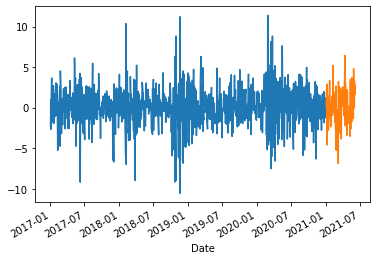

In [30]:
train.plot()
test.plot()

In [31]:
auto_arima_model.fit(train)


ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [32]:
future_forecast = auto_arima_model.predict(n_periods=len(test), dynamic= True)

In [33]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).iplot()

In [34]:
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

NameError: name 'model' is not defined

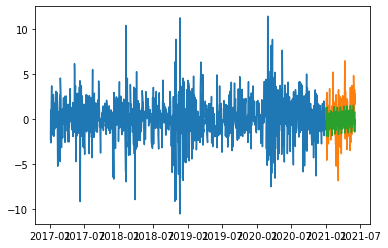

In [687]:
#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(test, label='Valid')
plt.plot(future_forecast, label='Prediction')
plt.show()

In [636]:
base_arima_model2 = auto_arima(df.Close, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


C:\Users\rlarl\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10999.924, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11027.706, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11001.509, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11004.887, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11031.071, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10999.592, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10998.035, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10999.066, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10998.781, Time=1.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=11002.192, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.582 seconds


In [637]:
train2 = df.Close[df.Close.index < '2021-01-01']
test2 = df.Close[df.Close.index >= '2021-01-01']

<AxesSubplot:xlabel='Date'>

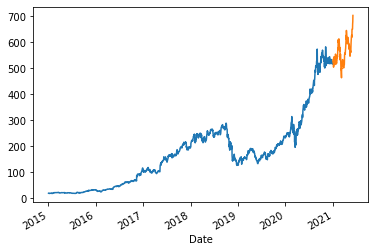

In [638]:
train2.plot()
test2.plot()

In [639]:
base_arima_model2.fit(train2)

ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True)

In [640]:
future_forecast2 = base_arima_model2.predict(n_periods=len(test2), Dynamic=True)


In [641]:
future_forecast2 = pd.DataFrame(future_forecast2,index = test2.index,columns=['Prediction2'])
result_df = pd.concat([test2,future_forecast2],axis=1)
result_df.iplot()

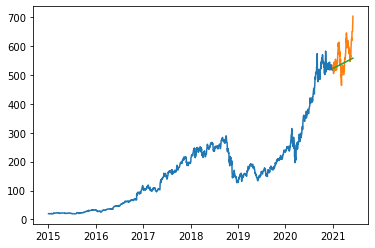

In [642]:
plt.plot(train2, label='Train')
plt.plot(test2, label='Valid')
plt.plot(future_forecast2, label='Prediction')
plt.show()


In [583]:
result_df

,Close,Prediction2
Date,,
2021-01-04,524.539978,523.349659
2021-01-05,536.190002,523.650953
2021-01-06,504.579987,524.077895
2021-01-07,533.760010,524.504836
2021-01-08,531.070007,524.931778
...,...,...
2021-05-28,649.780029,566.345095
2021-06-01,650.580017,566.772037
2021-06-02,671.130005,567.198978


(array([0.00142272, 0.00369906, 0.01308898, 0.05890041, 0.20515553,
        0.13885701, 0.03357608, 0.00341452, 0.00113817, 0.00085363]),
 array([-10.38111455,  -8.20770281,  -6.03429108,  -3.86087934,
         -1.6874676 ,   0.48594414,   2.65935587,   4.83276761,
          7.00617935,   9.17959108,  11.35300282]),
 <BarContainer object of 10 artists>)

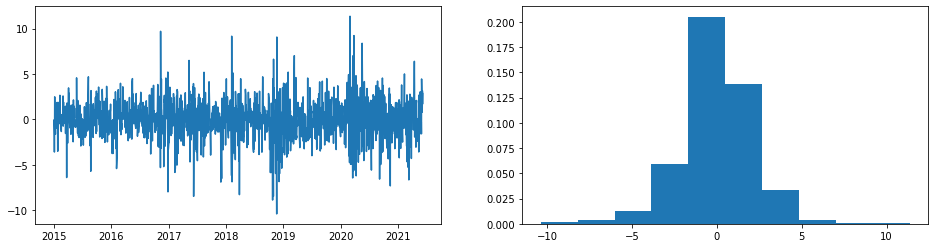

In [584]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

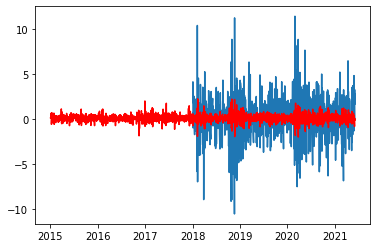

In [585]:
plt.plot(df.daily_change)
plt.plot(result.fittedvalues, color='red')
plt.show()

In [ ]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

In [ ]:
start = datetime.datetime(2020,2,1)
end = datetime.datetime(2020,10,11)

In [ ]:
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [ ]:
Symbols = companies['Symbol'].tolist()

In [ ]:
# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:  
    
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

In [ ]:
stock_final.head()

In [ ]:
https://trends.google.com/trends/explore?q=nvidia&geo=US

In [ ]:
https://docs.github.com/en/github/setting-up-and-managing-your-github-profile/managing-contribution-graphs-on-your-profile/why-are-my-contributions-not-showing-up-on-my-profile